# Physics-informed KAN: CFD

# Import PYKAN, an implementation of KAN

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan

  Cloning https://github.com/KindXiaoming/pykan to /tmp/pip-req-build-hwzc20ct
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan /tmp/pip-req-build-hwzc20ct
  Resolved https://github.com/KindXiaoming/pykan to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done


# Define KAN and physical problem (NACA Airfoil in an incompressible NSE setting)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch import autograd
from kan import KAN, LBFGS
# Garbage Collector - use it like gc.collect()
import gc

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

rho = torch.tensor(1.0, device=device, requires_grad=False)
nu = torch.tensor(0.001, device=device, requires_grad=False)
eps = torch.tensor(1e-8, device=device, requires_grad=False)

# Existing domain parameters
width, height = 10.0, 2.0
# Definition of the grid, idea: train on small, refine with KAN
num_points_x, num_points_y = 100, 200 # carefull --> VRAM is limiting factor

# Extend the domain grid
x = torch.linspace(0, width, num_points_x, device=device, requires_grad=False)
y = torch.linspace(0, height, num_points_y, device=device, requires_grad=False)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
coordinates.requires_grad = True


model = KAN(width=[2,3,3,3], grid=5, k=3, grid_eps=1.0,
            noise_scale=0.25).to(device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)


def generate_naca_airfoil(naca='2412', num_points=100, chord_length=1.0):
    m = int(naca[0]) / 100.0  # Maximum camber
    p = int(naca[1]) / 10.0   # Location of maximum camber
    t = int(naca[2:]) / 100.0 # Maximum thickness

    x = np.linspace(0, chord_length, num_points)
    yt = (t / 0.2) * chord_length * (
        0.2969 * np.sqrt(x / chord_length) -
        0.1260 * (x / chord_length) -
        0.3516 * (x / chord_length)**2 +
        0.2843 * (x / chord_length)**3 -
        0.1036 * (x / chord_length)**4
    )

    # Check if the airfoil is a symmetrical one (no camber)
    if p == 0:
        yc = np.zeros_like(x)
        dyc_dx = np.zeros_like(x)
    else:
        yc = np.where(x < p * chord_length, m * x / (p ** 2) * (2 * p - x / chord_length),
                      m * (chord_length - x) / ((1 - p) ** 2) * (1 + x / chord_length - 2 * p))
        dyc_dx = np.where(x < p * chord_length, 2 * m / (p ** 2) * (p - x / chord_length),
                          2 * m / ((1 - p) ** 2) * (p - x / chord_length))

    theta = np.arctan(dyc_dx)

    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Combine upper and lower surfaces
    x_airfoil = np.concatenate([x_upper, x_lower[::-1]])
    y_airfoil = np.concatenate([y_upper, y_lower[::-1]])

    return x_airfoil, y_airfoil


# Generate NACA airfoil coordinates
x_airfoil, y_airfoil = generate_naca_airfoil()
x_airfoil = torch.tensor(x_airfoil, device=device)
y_airfoil = torch.tensor(y_airfoil, device=device)

# Center the airfoil in the domain
airfoil_center = torch.tensor([width / 2, height / 2], device=device)
x_airfoil += airfoil_center[0] - x_airfoil.mean()
y_airfoil += airfoil_center[1] - y_airfoil.mean()

# Create a mask for the airfoil surface
airfoil_mask = torch.zeros(coordinates.size(0), dtype=torch.bool, device=device)
for i in range(len(x_airfoil)):
    distance = torch.sqrt((coordinates[:, 0] - x_airfoil[i]) ** 2 +
                          (coordinates[:, 1] - y_airfoil[i]) ** 2)
    airfoil_mask |= (distance <= 0.05)  # Adjust the threshold as needed

# residuals of boundary conditions = physics as loss function
def navier_stokes_residuals_airfoil(coords):
    coords = coords.clone().detach().requires_grad_(True)
    y_pred = model(coords)
    grads = batch_jacobian(model, coords, create_graph=True)
    hessians = batch_hessian(model, coords)
    # Fixing of the meaning of each output-node
    u, v, p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    # Gradients
    u_x, u_y = grads[:, 0, 0], grads[:, 0, 1]
    v_x, v_y = grads[:, 1, 0], grads[:, 1, 1]
    p_x, p_y = grads[:, 2, 0], grads[:, 2, 1]
    # Hessians
    u_xx, u_yy = hessians[:, 0, 0], hessians[:, 0, 1]
    v_xx, v_yy = hessians[:, 1, 0], hessians[:, 1, 1]
    # Additional equality constraints: h(x)=0
    continuity = u_x + v_y + eps * p
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_xx + v_yy)

    # Boundary conditions channel
    no_slip_mask = (coords[:, 1] == 0) | (coords[:, 1] == height)
    inlet_mask = (coords[:, 0] == 0)
    outlet_mask = (coords[:, 0] == width)

    # No-slip condition on the airfoil surface
    airfoil_loss = torch.mean(u[airfoil_mask] ** 2 + v[airfoil_mask] ** 2)

    # Boundary conditions airfoil
    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)
    inlet_loss = torch.mean((u[inlet_mask] - 2) ** 2)
    outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)

    #Loss function
    bc_loss = no_slip_loss + inlet_loss + outlet_pressure_loss + airfoil_loss
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + bc_loss
    return total_loss

def train_airfoil():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    steps = 20  # Number of training steps, 20 sufficient, 200 better / next step: refine grid
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals_airfoil(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
         # Free up memory after each step
        torch.cuda.empty_cache()  # Clear GPU memory cache
        gc.collect()              # Trigger garbage collection

        if step % 5 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)

writer = SummaryWriter()

train_airfoil()

writer.close()


Using device: cuda
checkpoint directory created: ./model
saving model version 0.0


Step: 15 | Loss: 0.102: 100%|██████████| 20/20 [03:52<00:00, 11.62s/it]


In [ ]:
## refine model
# model = model.refine(10)

In [ ]:
## retrain
#writer = SummaryWriter()
#
#train_airfoil()
#
#writer.close()

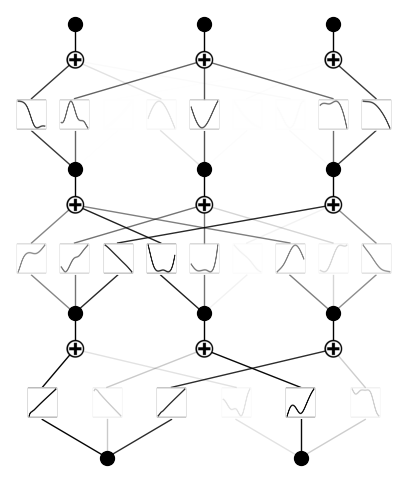

In [ ]:
model.plot()

# Extract predictions and plot on coarse grid

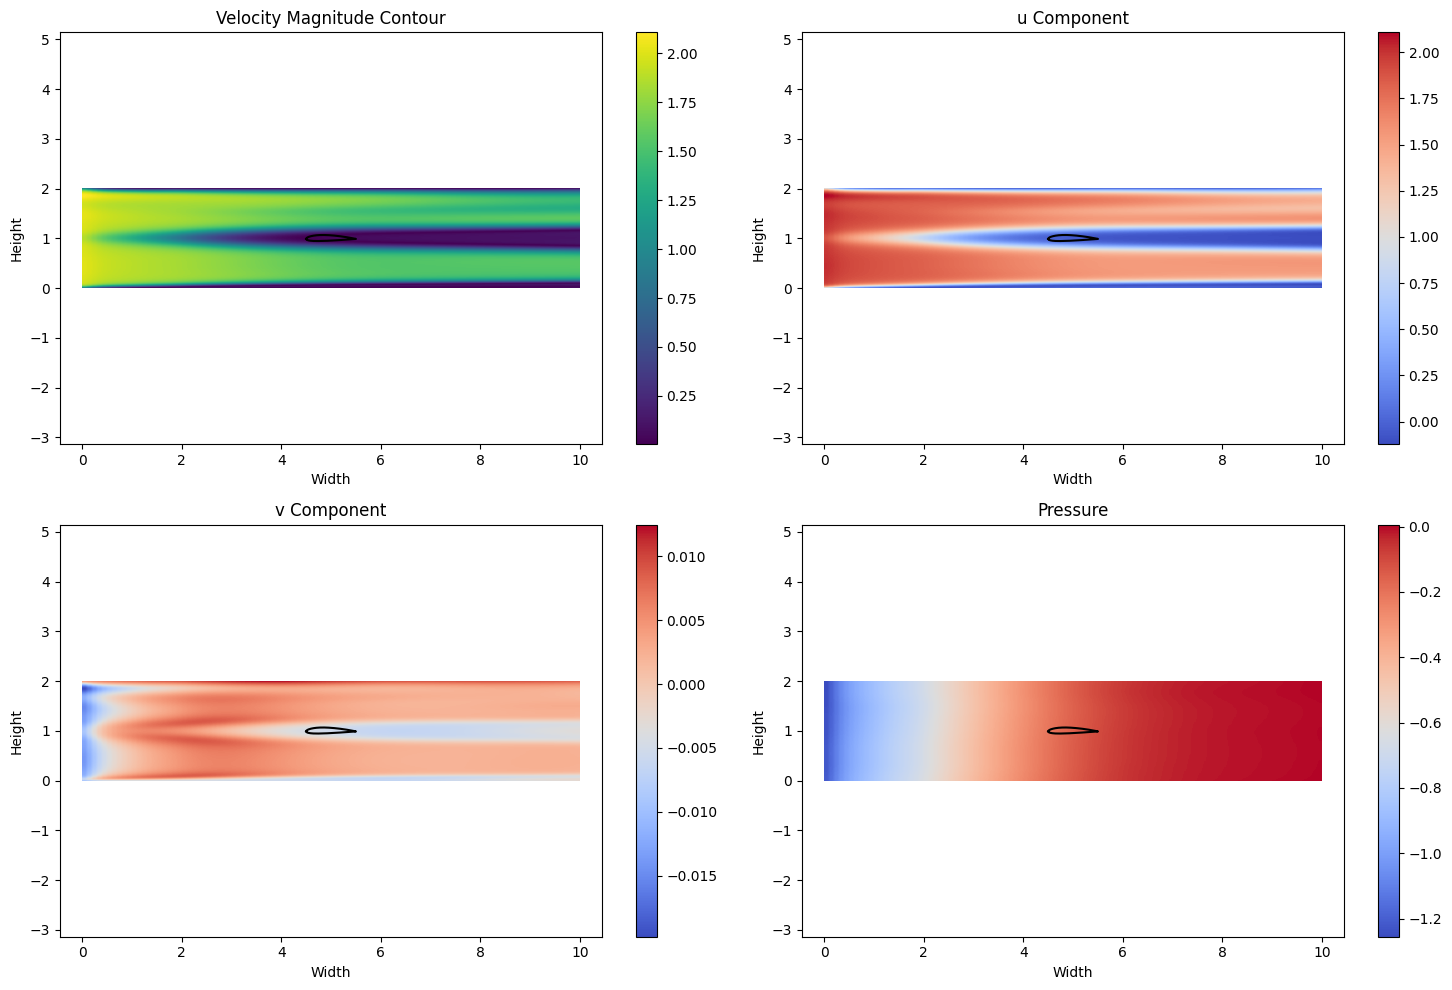

In [ ]:
# Extracting predictions
u_pred = model(coordinates)[:, 0].detach().reshape(num_points_x, num_points_y).T.cpu()
v_pred = model(coordinates)[:, 1].detach().reshape(num_points_x, num_points_y).T.cpu()
p_pred = model(coordinates)[:, 2].detach().reshape(num_points_x, num_points_y).T.cpu()

# Velocity Magnitude
magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2).cpu()

# Airfoil coordinates (converted to numpy for plotting)
x_airfoil_np = x_airfoil.cpu().numpy()
y_airfoil_np = y_airfoil.cpu().numpy()

# Plotting all subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Velocity Magnitude
im0 = axs[0, 0].imshow(magnitude, extent=(0, width, 0, height), origin='lower', cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0])
axs[0, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 0].set_title('Velocity Magnitude Contour')
axs[0, 0].set_xlabel('Width')
axs[0, 0].set_ylabel('Height')
axs[0, 0].axis('equal')

# u Component
im1 = axs[0, 1].imshow(u_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im1, ax=axs[0, 1])
axs[0, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 1].set_title('u Component')
axs[0, 1].set_xlabel('Width')
axs[0, 1].set_ylabel('Height')
axs[0, 1].axis('equal')

# v Component
im2 = axs[1, 0].imshow(v_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im2, ax=axs[1, 0])
axs[1, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 0].set_title('v Component')
axs[1, 0].set_xlabel('Width')
axs[1, 0].set_ylabel('Height')
axs[1, 0].axis('equal')

# Pressure
im3 = axs[1, 1].imshow(p_pred, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im3, ax=axs[1, 1])
axs[1, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 1].set_title('Pressure')
axs[1, 1].set_xlabel('Width')
axs[1, 1].set_ylabel('Height')
axs[1, 1].axis('equal')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Refine Predictions based on trained KAN

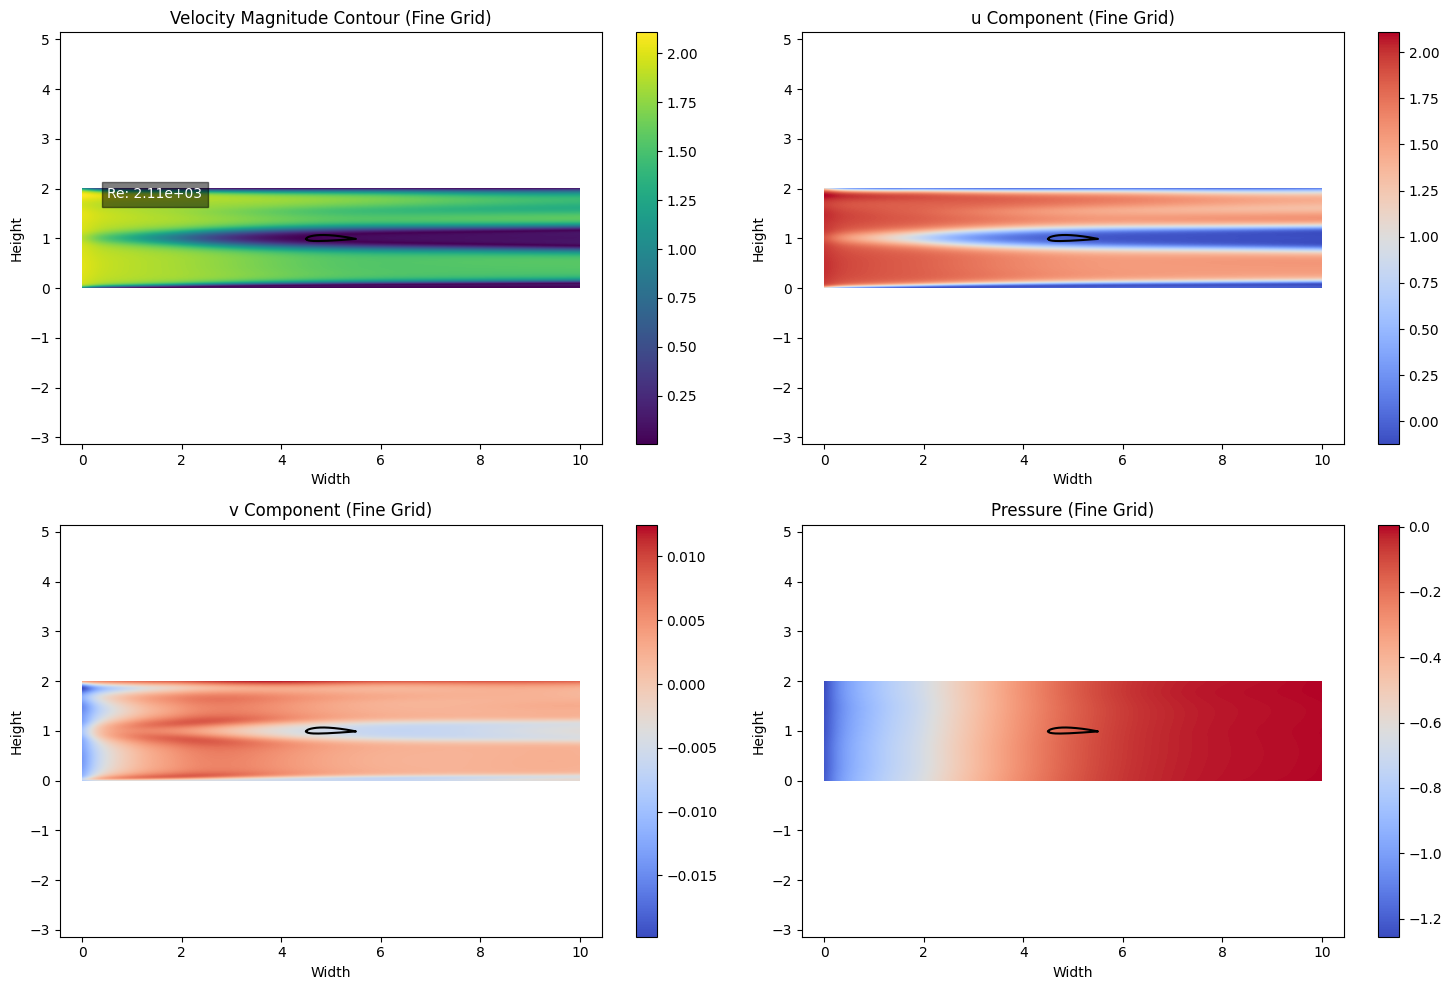

In [ ]:
gc.collect()

# Define a finer grid for predictions
num_points_x_fine = 2000  # Increase the number of points along the x-axis
num_points_y_fine = 2000  # Increase the number of points along the y-axis

# Create the finer grid
x_fine = torch.linspace(0, width, num_points_x_fine, device=device, requires_grad=False)
y_fine = torch.linspace(0, height, num_points_y_fine, device=device, requires_grad=False)
X_fine, Y_fine = torch.meshgrid(x_fine, y_fine, indexing='ij')
coordinates_fine = torch.stack([X_fine.flatten(), Y_fine.flatten()], dim=1).to(device)

# Make predictions on the finer grid
u_pred_fine = model(coordinates_fine)[:, 0].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()
v_pred_fine = model(coordinates_fine)[:, 1].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()
p_pred_fine = model(coordinates_fine)[:, 2].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()

# Velocity Magnitude on the finer grid
magnitude_fine = torch.sqrt(u_pred_fine ** 2 + v_pred_fine ** 2)

# Airfoil coordinates (converted to numpy for plotting)
x_airfoil_np = x_airfoil.cpu().numpy()
y_airfoil_np = y_airfoil.cpu().numpy()

# Compute dynamic viscosity
mu = rho.item() * nu.item()

# Compute the characteristic length (chord length of the airfoil)
L = (x_airfoil.max() - x_airfoil.min()).item()

# Compute the characteristic velocity (maximum velocity magnitude)
U = magnitude_fine.max().item()

# Compute Reynolds number
Re = (rho.item() * U * L) / mu

# Plotting all subplots with fine predictions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Velocity Magnitude
im0 = axs[0, 0].imshow(magnitude_fine, extent=(0, width, 0, height), origin='lower', cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0])
axs[0, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 0].set_title('Velocity Magnitude Contour (Fine Grid)')
axs[0, 0].set_xlabel('Width')
axs[0, 0].set_ylabel('Height')
axs[0, 0].axis('equal')

# Display Reynolds number in the top left subplot
axs[0, 0].text(0.05 * width, 0.9 * height, f'Re: {Re:.2e}', color='white',
               fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

# u Component
im1 = axs[0, 1].imshow(u_pred_fine, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im1, ax=axs[0, 1])
axs[0, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 1].set_title('u Component (Fine Grid)')
axs[0, 1].set_xlabel('Width')
axs[0, 1].set_ylabel('Height')
axs[0, 1].axis('equal')

# v Component
im2 = axs[1, 0].imshow(v_pred_fine, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im2, ax=axs[1, 0])
axs[1, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 0].set_title('v Component (Fine Grid)')
axs[1, 0].set_xlabel('Width')
axs[1, 0].set_ylabel('Height')
axs[1, 0].axis('equal')

# Pressure
im3 = axs[1, 1].imshow(p_pred_fine, extent=(0, width, 0, height), origin='lower', cmap='coolwarm')
fig.colorbar(im3, ax=axs[1, 1])
axs[1, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 1].set_title('Pressure (Fine Grid)')
axs[1, 1].set_xlabel('Width')
axs[1, 1].set_ylabel('Height')
axs[1, 1].axis('equal')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()




# Zoom In

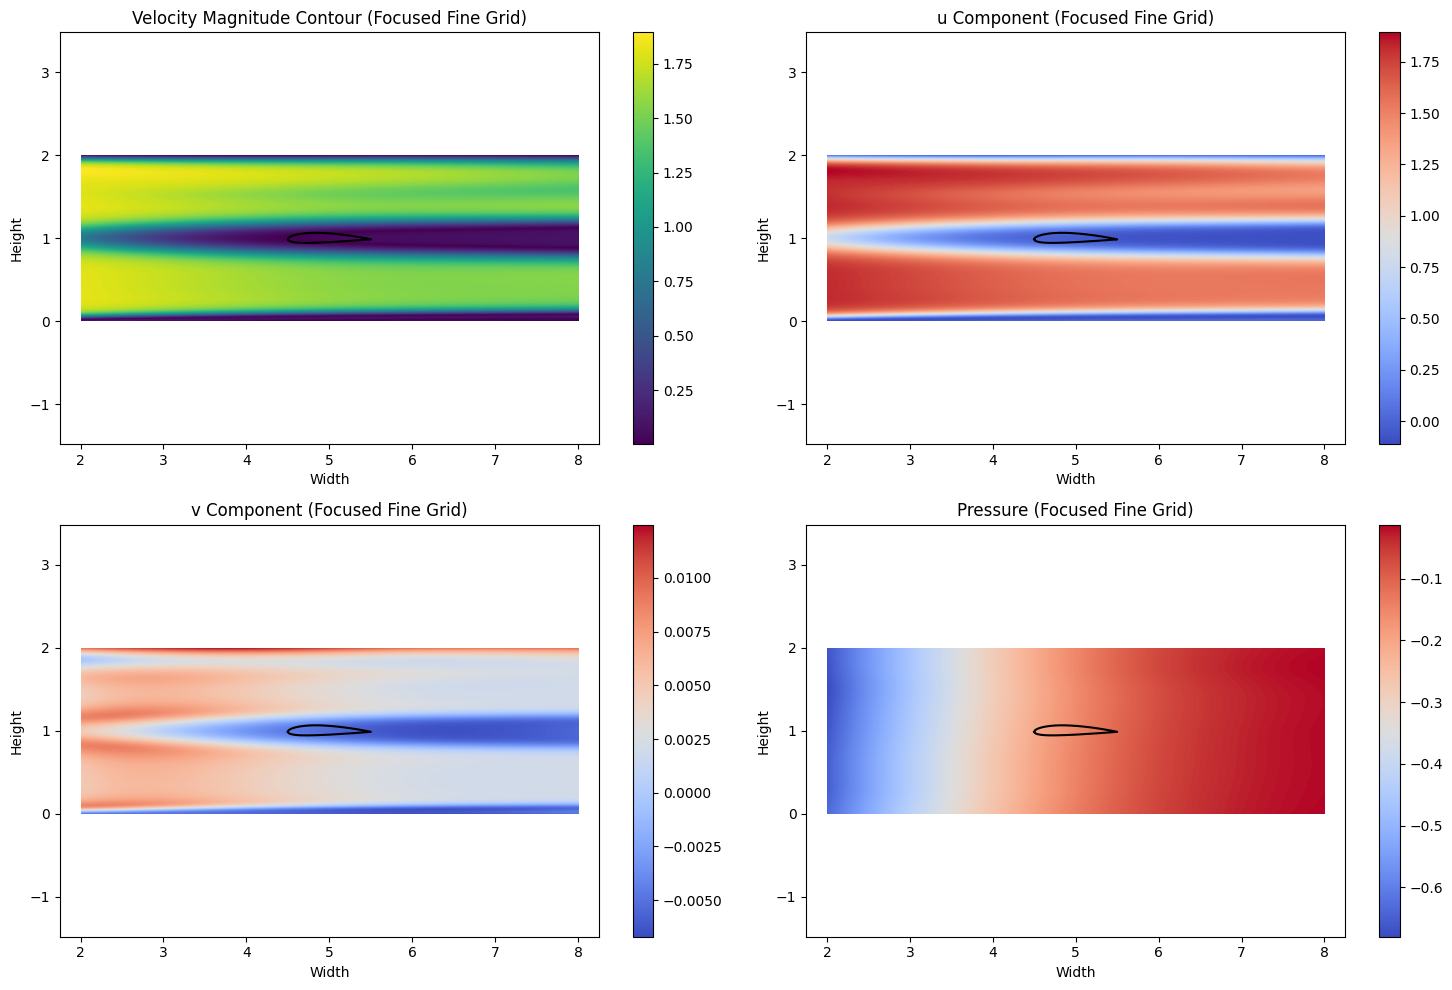

In [ ]:
gc.collect()

# Calculate bounds around the airfoil
chord_length = x_airfoil_np.max() - x_airfoil_np.min()  # Estimate chord length
x_min = x_airfoil_np.min() - 2.5 * chord_length         # 10% ahead of the airfoil
x_max = x_airfoil_np.max() + 2.5 * chord_length         # 10% behind the airfoil
#y_min = y_airfoil_np.min() - 2.5 * chord_length         # 10% below the airfoil
#y_max = y_airfoil_np.max() + 2.5 * chord_length         # 10% above the airfoil

y_min, y_max = 0, height

# Define a finer grid within the focused region
num_points_x_fine = 2000  # Number of points along the x-axis within the focused region
num_points_y_fine = 2000  # Number of points along the y-axis within the focused region

# Create the focused finer grid
x_fine = torch.linspace(x_min, x_max, num_points_x_fine, device=device, requires_grad=False)
y_fine = torch.linspace(y_min, y_max, num_points_y_fine, device=device, requires_grad=False)
X_fine, Y_fine = torch.meshgrid(x_fine, y_fine, indexing='ij')
coordinates_fine = torch.stack([X_fine.flatten(), Y_fine.flatten()], dim=1).to(device)

# Make predictions on the focused finer grid
u_pred_fine = model(coordinates_fine)[:, 0].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()
v_pred_fine = model(coordinates_fine)[:, 1].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()
p_pred_fine = model(coordinates_fine)[:, 2].detach().reshape(num_points_x_fine, num_points_y_fine).T.cpu()

# Velocity Magnitude on the finer grid
magnitude_fine = torch.sqrt(u_pred_fine ** 2 + v_pred_fine ** 2)

# Airfoil coordinates (converted to numpy for plotting)
x_airfoil_np = x_airfoil.cpu().numpy()
y_airfoil_np = y_airfoil.cpu().numpy()

# Plotting all subplots with focused fine predictions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Velocity Magnitude
im0 = axs[0, 0].imshow(magnitude_fine, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0])
axs[0, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 0].set_title('Velocity Magnitude Contour (Focused Fine Grid)')
axs[0, 0].set_xlabel('Width')
axs[0, 0].set_ylabel('Height')
axs[0, 0].axis('equal')

# u Component
im1 = axs[0, 1].imshow(u_pred_fine, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='coolwarm')
fig.colorbar(im1, ax=axs[0, 1])
axs[0, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[0, 1].set_title('u Component (Focused Fine Grid)')
axs[0, 1].set_xlabel('Width')
axs[0, 1].set_ylabel('Height')
axs[0, 1].axis('equal')

# v Component
im2 = axs[1, 0].imshow(v_pred_fine, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='coolwarm')
fig.colorbar(im2, ax=axs[1, 0])
axs[1, 0].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 0].set_title('v Component (Focused Fine Grid)')
axs[1, 0].set_xlabel('Width')
axs[1, 0].set_ylabel('Height')
axs[1, 0].axis('equal')

# Pressure
im3 = axs[1, 1].imshow(p_pred_fine, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='coolwarm')
fig.colorbar(im3, ax=axs[1, 1])
axs[1, 1].plot(x_airfoil_np, y_airfoil_np, '-k', linewidth=1.5, label='Airfoil')  # Overlay airfoil
axs[1, 1].set_title('Pressure (Focused Fine Grid)')
axs[1, 1].set_xlabel('Width')
axs[1, 1].set_ylabel('Height')
axs[1, 1].axis('equal')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


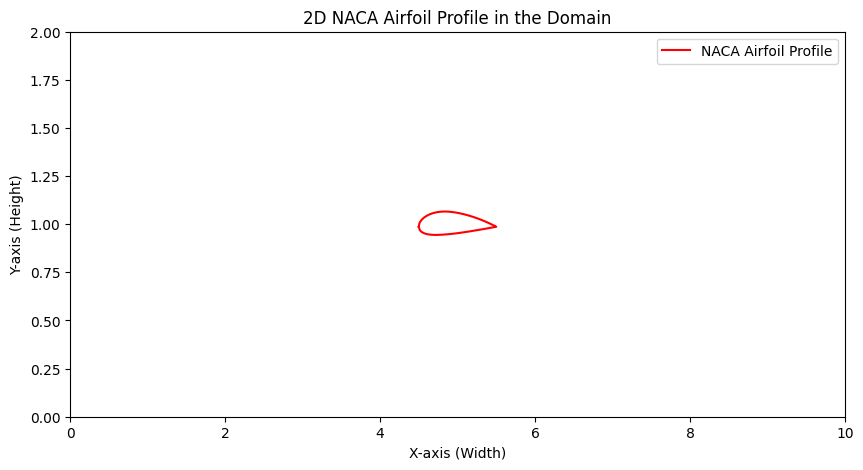

In [ ]:
# Convert the airfoil coordinates to CPU and NumPy for plotting
x_airfoil_np = x_airfoil.cpu().numpy()
y_airfoil_np = y_airfoil.cpu().numpy()

# Set up the 2D plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the 2D NACA airfoil profile
ax.plot(x_airfoil_np, y_airfoil_np, 'r-', label='NACA Airfoil Profile')

# Plot the domain boundaries for reference
ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Labels and title
ax.set_title('2D NACA Airfoil Profile in the Domain')
ax.set_xlabel('X-axis (Width)')
ax.set_ylabel('Y-axis (Height)')
ax.legend()

plt.show()


# Automatic Equation Modeling

In [ ]:
gc.collect()
model.suggest_symbolic(0,0,0)
model.suggest_symbolic(1,0,0)
model.suggest_symbolic(2,0,0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 152.01 GiB. GPU 0 has a total capacity of 39.56 GiB of which 26.56 GiB is free. Process 262612 has 13.00 GiB memory in use. Of the allocated memory 11.10 GiB is allocated by PyTorch, and 1.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#prune
#model = model.rewind('0.1')
model = model.prune_node(threshold=1e-6)
#model = model.prune()

In [ ]:
model.plot()

In [ ]:
model.auto_symbolic()

# Retrain Symbolic Version

In [ ]:
#writer = SummaryWriter()

#train_airfoil()

#writer.close()

In [ ]:
from sympy import nsimplify

In [ ]:
formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 3))

# Check Batching to avoid memory overflow

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch import autograd
from kan import *
# Garbage Collector - use it like gc.collect()
import gc

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

rho = torch.tensor(1.0, device=device, requires_grad=False)
nu = torch.tensor(0.001, device=device, requires_grad=False)
eps = torch.tensor(1e-8, device=device, requires_grad=False)

# Existing domain parameters
width, height = 10.0, 2.0
# Definition of the grid, idea: train on small, refine with KAN
num_points_x, num_points_y = 1000, 2000 # carefull --> VRAM is limiting factor

# Extend the domain grid
x = torch.linspace(0, width, num_points_x, device=device, requires_grad=False)
y = torch.linspace(0, height, num_points_y, device=device, requires_grad=False)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
coordinates.requires_grad = True


model = KAN(width=[2,3,3,3], grid=5, k=3, grid_eps=1.0,
            noise_scale=0.25).to(device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)


def generate_naca_airfoil(naca='2412', num_points=100, chord_length=1.0):
    m = int(naca[0]) / 100.0  # Maximum camber
    p = int(naca[1]) / 10.0   # Location of maximum camber
    t = int(naca[2:]) / 100.0 # Maximum thickness

    x = np.linspace(0, chord_length, num_points)
    yt = (t / 0.2) * chord_length * (
        0.2969 * np.sqrt(x / chord_length) -
        0.1260 * (x / chord_length) -
        0.3516 * (x / chord_length)**2 +
        0.2843 * (x / chord_length)**3 -
        0.1036 * (x / chord_length)**4
    )

    # Check if the airfoil is a symmetrical one (no camber)
    if p == 0:
        yc = np.zeros_like(x)
        dyc_dx = np.zeros_like(x)
    else:
        yc = np.where(x < p * chord_length, m * x / (p ** 2) * (2 * p - x / chord_length),
                      m * (chord_length - x) / ((1 - p) ** 2) * (1 + x / chord_length - 2 * p))
        dyc_dx = np.where(x < p * chord_length, 2 * m / (p ** 2) * (p - x / chord_length),
                          2 * m / ((1 - p) ** 2) * (p - x / chord_length))

    theta = np.arctan(dyc_dx)

    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Combine upper and lower surfaces
    x_airfoil = np.concatenate([x_upper, x_lower[::-1]])
    y_airfoil = np.concatenate([y_upper, y_lower[::-1]])

    return x_airfoil, y_airfoil


# Generate NACA airfoil coordinates
x_airfoil, y_airfoil = generate_naca_airfoil()
x_airfoil = torch.tensor(x_airfoil, device=device)
y_airfoil = torch.tensor(y_airfoil, device=device)

# Center the airfoil in the domain
airfoil_center = torch.tensor([width / 2, height / 2], device=device)
x_airfoil += airfoil_center[0] - x_airfoil.mean()
y_airfoil += airfoil_center[1] - y_airfoil.mean()

# Create a mask for the airfoil surface
airfoil_mask = torch.zeros(coordinates.size(0), dtype=torch.bool, device=device)
for i in range(len(x_airfoil)):
    distance = torch.sqrt((coordinates[:, 0] - x_airfoil[i]) ** 2 +
                          (coordinates[:, 1] - y_airfoil[i]) ** 2)
    airfoil_mask |= (distance <= 0.05)  # Adjust the threshold as needed

# residuals of boundary conditions = physics as loss function
def navier_stokes_residuals_airfoil(coords):
    coords = coords.clone().detach().requires_grad_(True)
    y_pred = model(coords)
    grads = batch_jacobian(model, coords, create_graph=True)
    hessians = batch_hessian(model, coords)
    # Fixing of the meaning of each output-node
    u, v, p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    # Gradients
    u_x, u_y = grads[:, 0, 0], grads[:, 0, 1]
    v_x, v_y = grads[:, 1, 0], grads[:, 1, 1]
    p_x, p_y = grads[:, 2, 0], grads[:, 2, 1]
    # Hessians
    u_xx, u_yy = hessians[:, 0, 0], hessians[:, 0, 1]
    v_xx, v_yy = hessians[:, 1, 0], hessians[:, 1, 1]
    # Additional equality constraints: h(x)=0
    continuity = u_x + v_y + eps * p
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_xx + v_yy)

    # Boundary conditions channel
    no_slip_mask = (coords[:, 1] == 0) | (coords[:, 1] == height)
    inlet_mask = (coords[:, 0] == 0)
    outlet_mask = (coords[:, 0] == width)

    # No-slip condition on the airfoil surface
    airfoil_loss = torch.mean(u[airfoil_mask] ** 2 + v[airfoil_mask] ** 2)

    # Boundary conditions airfoil
    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)
    inlet_loss = torch.mean((u[inlet_mask] - 2) ** 2)
    outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)

    #Loss function
    bc_loss = no_slip_loss + inlet_loss + outlet_pressure_loss + airfoil_loss
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + bc_loss
    return total_loss

def train_airfoil():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    steps = 20  # Number of training steps, 20 sufficient, 200 better / next step: refine grid
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals_airfoil(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
         # Free up memory after each step
        torch.cuda.empty_cache()  # Clear GPU memory cache
        gc.collect()              # Trigger garbage collection

        if step % 5 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)

writer = SummaryWriter()

train_airfoil()

writer.close()
